# Summary:

The objective of this notebook is to participate in 'LLM : Detect AI generated text' competition where using a dataset of prompts and texts generated by humans and AI, we have to predict which one is generated by an AI. 
First, we use different datasets and combine them to prepare a dataset which has classes balanced. then , we clean tha data by stemming the text, removing stopwords and punctuations. After this, we convert text into numbers by Count Vectorizer and then finally we train an ML model on the final vector and test it on validation dataset before predicting the results of test dataset. The results on using different ML models is documented in last cell.

Version 2 : with Daigt Dataset and with DistilBert (Failed)
Version 3: with Daigt Subset and considering more Human Written Text vs AI Generated


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from numba import cuda
from nltk.tokenize import word_tokenize
import tensorflow_text as tftext
import tensorflow_hub as tfhub
import keras_nlp
import keras
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


# Loading the training CSV file

In [2]:
train_csv_loc = "/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
train_csv = pd.read_csv(train_csv_loc)
train_csv

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


# Loading the prompts CSV files

In [3]:
prompts_csv = "/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv"
pd.read_csv(prompts_csv)

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


# Analyzing test dataset

generated
0    1375
1       3
Name: text, dtype: int64


([<matplotlib.patches.Wedge at 0x7dd0ad1ce800>,
 [Text(-1.0999742722741532, 0.0075233194101512945, 'generated by students'),
  Text(1.099974272477764, -0.007523289640464896, 'generated by LLM')],
 [Text(-0.5999859666949926, 0.004103628769173433, '99.78%'),
  Text(0.599985966806053, -0.00410361253116267, '0.22%')])

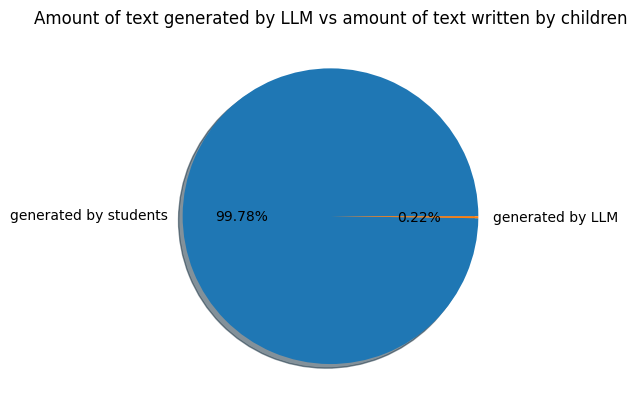

In [4]:
llm_generated_perc = train_csv.groupby('generated').count()['text']
print(llm_generated_perc)
plt.title("Amount of text generated by LLM vs amount of text written by children")
plt.pie(llm_generated_perc,labels=['generated by students','generated by LLM'],autopct = '%0.2f%%',shadow=True)

Only 3 out of 1378 entries are generated by LLM accounting for mere 0.2%. This is an extreme class imbalance.

prompt_id
0    708
1    670
Name: generated, dtype: int64


([<matplotlib.patches.Wedge at 0x7dd0ad2774f0>,
 [Text(-0.04763336781987195, 1.0989681807359741, 'Car-free cities'),
  Text(0.047633367819872305, -1.0989681807359741, 'Does the electoral college work?')],
 [Text(-0.025981836992657426, 0.5994371894923495, '51.38%'),
  Text(0.025981836992657617, -0.5994371894923495, '48.62%')])

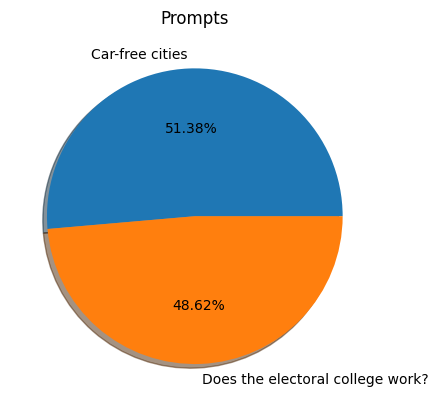

In [5]:
prompt_perc = train_csv.groupby('prompt_id').count()['generated']
print(prompt_perc)
plt.title("Prompts")
plt.pie(prompt_perc,labels=["Car-free cities","Does the electoral college work?"],autopct="%0.2f%%",shadow=True)

# Adding new data to prevent class imbalance

In [6]:
dataset_1_loc ='/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v6.csv'
aug_data1 = pd.read_csv(dataset_1_loc)
aug_data1 = aug_data1[aug_data1["prompt_id"]==2]
aug_data1["prompt_id"]=aug_data1['prompt_id']-2
aug_data1

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4195,0,The concept of car-free cities is becoming in...,Car-free cities,1
4196,0,Car-free cities: a vision for a healthier and...,Car-free cities,1
4197,0,The concept of car-free cities has gained pop...,Car-free cities,1
4198,0,Car-free cities are cities where cars are not...,Car-free cities,1


In [7]:
dataset_2_loc = '/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v7.csv'
aug_data2 = pd.read_csv(dataset_2_loc)
aug_data2 = aug_data2[aug_data2["prompt_id"]==12]
aug_data2["prompt_id"]=aug_data2['prompt_id']-11
aug_data2

,prompt_id,text,prompt_name,generated
4200,1,The electoral college is a system that is use...,Does the electoral college work?,1
4201,1,The electoral college system that is used to ...,Does the electoral college work?,1
4202,1,The electoral college is a system used in the...,Does the electoral college work?,1
4203,1,The electoral college is a system in which ci...,Does the electoral college work?,1
4204,1,The Electoral College is a system used in the...,Does the electoral college work?,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [8]:
aug_data_mistral = pd.concat([aug_data1,aug_data2],axis=0)
aug_data_mistral

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [9]:
google_palm = pd.read_csv('/kaggle/input/llm-generated-essay-using-palm-from-google-gen-ai/LLM_generated_essay_PaLM.csv').drop(columns=['id'])
google_palm = google_palm.drop(columns=['prompt_id'])
google_palm

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,"Dear Senator,\n\nI am writing to you today to ...",1.0


In [10]:
big_set =pd.read_csv('/kaggle/input/augmented-data-for-llm-detect-ai-generated-text/final_train.csv')
big_set_0_4000 = big_set[big_set['label']==0].iloc[0:4000,:] #first 2000 rows of human written texts
big_set_1_2600 = big_set[big_set['label']==1].iloc[0:2600,:] #first 600 rows of AI written texts
big_set_0_4000

,text,label
0,We should keep the Electoral College for a num...,0
2,Limiting car usage can actually be effective b...,0
4,"Dear Principal,\n\nAfter school or during scho...",0
5,"Many people think that aliens are real, but th...",0
8,I think if a student has a C average he or she...,0
...,...,...
6358,""" All of our development since World War 2 has...",0
6362,Some people do extracurricular activities and ...,0
6363,Exploring Venus would be a pretty amazing expe...,0
6366,You should participate in the Seagoing cowboys...,0


In [11]:
big_set_6600 = pd.concat([big_set_0_4000,big_set_1_2600],axis=0)
big_set_6600.rename(columns={'label':'generated'},inplace=True)
big_set_6600

,text,generated
0,We should keep the Electoral College for a num...,0
2,Limiting car usage can actually be effective b...,0
4,"Dear Principal,\n\nAfter school or during scho...",0
5,"Many people think that aliens are real, but th...",0
8,I think if a student has a C average he or she...,0
...,...,...
7005,The debate over whether children should be tau...,1
7013,I strongly believe that working in groups is ...,1
7014,The advantages of limiting car usage are evid...,1
7015,The use of E-dictionaries is increasingly popu...,1


In [12]:
aug_data_mistral = aug_data_mistral.drop(columns= ['prompt_name','prompt_id'])
aug_data_mistral

,text,generated
3500,Car-free cities are becoming increasingly pop...,1
3501,Car-free cities are becoming increasingly pop...,1
3502,Car-free cities are becoming increasingly pop...,1
3503,Car-free cities have become increasingly popu...,1
3504,Car-free cities are a growing concept in toda...,1
...,...,...
4895,The electoral college is one of the most disc...,1
4896,"Dear Sen. [Name],\n\nI am writing to express ...",1
4897,The electoral college is a system that is use...,1
4898,A strong electoral system is vital to the fun...,1


In [13]:
daigt_data = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')


Column names in the dataset: ['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven']


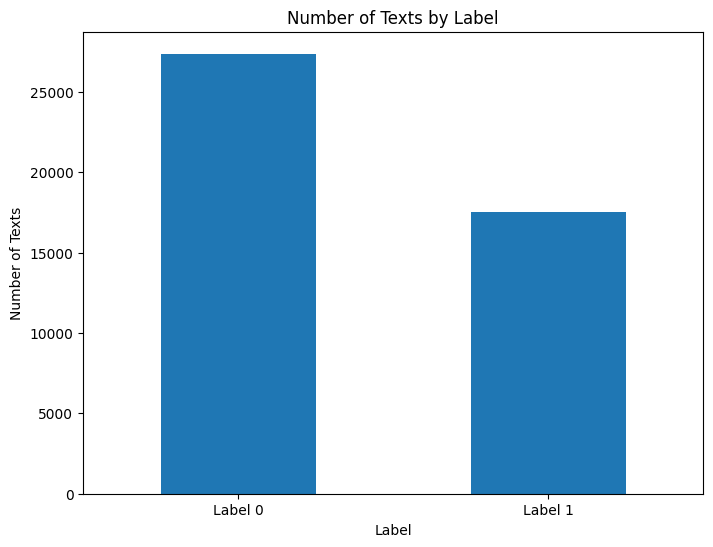

In [14]:
print("Column names in the dataset:", daigt_data.columns.tolist())

# If the 'generated' column is not found, we assume the original column name 'label' is still present.
# Let's use 'label' to check the distribution of labels (0 and 1).
label_column = 'label' if 'label' in daigt_data.columns else 'generated'
label_counts = daigt_data[label_column].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Number of Texts by Label')
plt.xlabel('Label')
plt.ylabel('Number of Texts')
plt.xticks([0, 1], ['Label 0', 'Label 1'], rotation=0)  # Set text labels for the x-axis
plt.show()

#the one with label 0 are Human written Text 
#Label 1 : AI Generated Text

In [15]:
daigt_data_0_4000 = daigt_data[daigt_data['label']==0].iloc[0:4000,:] #first 2000 rows of human written texts
daigt_data_1_2600 = daigt_data[daigt_data['label']==1].iloc[:2600,:] #first 600 rows of AI written texts
daigt_data_0_4000

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
3995,Summer projects designed by teachers can boost...,0,Summer projects,persuade_corpus,False
3996,Keeping your mind working during the summer wi...,0,Summer projects,persuade_corpus,False
3997,Some schools require summer projects make sure...,0,Summer projects,persuade_corpus,False
3998,Should schools allow the students or teachers ...,0,Summer projects,persuade_corpus,False


In [16]:
daigt_data_6600 = pd.concat([daigt_data_0_4000,daigt_data_1_2600],axis=0)
daigt_data_6600.rename(columns={'label':'generated'},inplace=True)
daigt_data_6600

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
28591,"Some people may ask when someone asks them ""w...",1,Seeking multiple opinions,mistral7binstruct_v2,False
28592,Some schools offer distance learning as an opt...,1,Distance learning,darragh_claude_v7,False
28593,Busch Gardens is a popular amusement park loca...,1,Distance learning,mistral7binstruct_v1,False
28594,Technology has revolutionized the way people ...,1,Distance learning,mistral7binstruct_v2,False


In [17]:
# Drop the specified columns
columns_to_drop = ['prompt_name', 'source', 'RDizzl3_seven']
daigt_data_6600.drop(columns=columns_to_drop, inplace=True, errors='ignore')  # errors='ignore' in case columns don't exist

# Rename the 'label' column to 'generated'
daigt_data_6600.rename(columns={'label': 'generated'}, inplace=True)

In [18]:
daigt_data_6600

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0
...,...,...
28591,"Some people may ask when someone asks them ""w...",1
28592,Some schools offer distance learning as an opt...,1
28593,Busch Gardens is a popular amusement park loca...,1
28594,Technology has revolutionized the way people ...,1


Dropped prompt name column as it was unnecessary because prompt Id is already given.

In [19]:
train_csv= train_csv.drop(columns=['id','prompt_id'])
train_csv

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


Dropped id column as it is not necessary for training and also to concatenate with new dataset

prompt_id dropped because prompt_id column wasn't there in the biggest dataset posing a problem in concatenating. 

# Final dataset to be used

In [20]:
final_data = pd.concat([train_csv,aug_data_mistral,big_set_6600,google_palm,daigt_data_6600],axis=0)
final_data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
28591,"Some people may ask when someone asks them ""w...",1.0
28592,Some schools offer distance learning as an opt...,1.0
28593,Busch Gardens is a popular amusement park loca...,1.0
28594,Technology has revolutionized the way people ...,1.0


Final dataset is completed and ready to work on

In [21]:
final_data['text'].index = np.arange(0,final_data.shape[0])
final_data['text']

0        Cars. Cars have been around since they became ...
1        Transportation is a large necessity in most co...
2        "America's love affair with it's vehicles seem...
3        How often do you ride in a car? Do you drive a...
4        Cars are a wonderful thing. They are perhaps o...
                               ...                        
17357     Some people may ask when someone asks them "w...
17358    Some schools offer distance learning as an opt...
17359    Busch Gardens is a popular amusement park loca...
17360     Technology has revolutionized the way people ...
17361    I strongly believe that schools should not imp...
Name: text, Length: 17362, dtype: object

In [22]:
final_data = final_data.drop_duplicates()
final_data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
28590,"As an 8th grader, I believe that seeking guida...",1.0
28591,"Some people may ask when someone asks them ""w...",1.0
28592,Some schools offer distance learning as an opt...,1.0
28593,Busch Gardens is a popular amusement park loca...,1.0


([<matplotlib.patches.Wedge at 0x7dd0ab042bf0>,
 [Text(-0.16610657351138736, 1.0873861348372555, 'generated by AI'),
  Text(0.166106573511387, -1.0873861348372558, 'not generated by AI')],
 [Text(-0.09060358555166582, 0.5931197099112303, '54.83%'),
  Text(0.09060358555166562, -0.5931197099112303, '45.17%')])

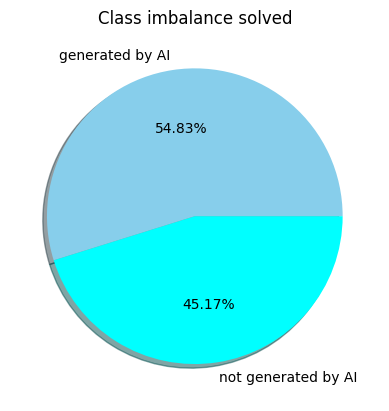

In [23]:
classes = final_data.groupby('generated').count()['text']
plt.title('Class imbalance solved')
plt.pie(classes, labels=['generated by AI','not generated by AI'],colors=['skyblue','cyan'],shadow=True,autopct='%0.2f%%')

In [24]:
def cleantext(data) :
    stemtext = []
    len_text = []
    para = data['text'].tolist()
    for paragraph in para:
        char = [char for char in paragraph if char not in string.punctuation]
        word = "".join(char).split(" ")
        words = [word.lower() for word in word if word not in stopwords.words('english')]
        stemwords = [SnowballStemmer('english').stem(word) for word in words]
        len_text.append(len(stemwords))
        stemtext.append(" ".join(stemwords))
    return stemtext , len_text

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [26]:
traintext = cleantext(final_data)[0]

In [27]:
np.mean(cleantext(final_data)[1])

233.6655749210434

Average length of essays after cleaning the dataset is 224 words

# Splitting the dataset into train and test

In [28]:
x_train, x_test ,y_train , y_test = train_test_split(final_data.iloc[:,0:2], final_data['generated'],test_size=0.2)
x_train['labels'] = y_train
x_test['labels'] = y_test

In [29]:
x_train

,text,generated,labels
556,Cell Phone V.S. Driving\n\nToday technology ha...,0.0,0.0
736,Should Cellphones Be Used While Driving?\n\nOr...,0.0,0.0
1239,Our country's history with cars date back a fe...,0.0,0.0
1164,Imagine being stuck in traffic again for the f...,0.0,0.0
2007,In this world we live in everyone wants to get...,0.0,0.0
...,...,...,...
603,There are many advantages of having limitation...,0.0,0.0
29,In the generation we are living in today cars ...,0.0,0.0
26162,"Hey there! So, you wanna know how older stude...",1.0,1.0
1755,People are becoming more and more reliant on c...,0.0,0.0


# Preprocessing and fitting dataset in DistBERT model

In [30]:
# import tensorflow as tf
# import tensorflow_hub as tfhub

# # Define the input layer
# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

# # Use a DistilBERT preprocessor
# preprocessor = tfhub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# # Preprocess the input
# encoder_inputs = preprocessor(text_input)

# # The DistilBERT model on TF Hub expects only 'input_word_ids' and 'input_mask'
# # We will not pass 'input_type_ids' to the model
# encoder_inputs = {key: val for key, val in encoder_inputs.items() if key != 'input_type_ids'}

# # Use a DistilBERT encoder
# encoder = tfhub.KerasLayer(
#     "https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1",
#     trainable=True)

# # Pass the preprocessed input to DistilBERT encoder
# outputs = encoder(encoder_inputs)

# # DistilBERT does not output 'pooled_output', only 'sequence_output'
# # For pooled output, we can use `[:,0,:]` which corresponds to the CLS token
# pooled_output = outputs["sequence_output"][:, 0, :]

# # Continue with the rest of your model
# dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
# dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(dense_1)
# dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
# dropout1 = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)
# dense_3 = tf.keras.layers.Dense(16, activation='relu')(dropout1)

# # Final output layer
# dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dense_3)

# # Construct the model
# model = tf.keras.Model(inputs=text_input, outputs=dense_out)

# # Get the model summary
# model.summary()


In [31]:
# # Fit
# classifier.fit(x=x_train, 
#                y=y_train,
#                validation_data=(x_test, y_test),
#                epochs=1,
#                batch_size=64
#               )

In [32]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = tfhub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = tfhub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-512-a-8/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      
sequence_output = outputs["sequence_output"] 

dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout1 = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)
dense_3 = tf.keras.layers.Dense(16,activation='relu')(dropout1)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout1)


model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00005),
              loss='binary_crossentropy',
              metrics=["accuracy"])
metric = 'val_accuracy'
checkpoint_filepath = 'checkpoint.hdf5'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                    monitor=metric,
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='max'), 
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience=0,
                                                  restore_best_weights=True)
                ]
history = model.fit(x_train['text'], x_train['labels'] , batch_size=8,
                    epochs=1 , validation_data=(x_test['text'], x_test['labels']))
model.save("bertmodel_v2")

1710/1710 [==============================] - 273s 138ms/step - loss: 0.1715 - accuracy: 0.9370 - val_loss: 0.0788 - val_accuracy: 0.9789


In [34]:
final_test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
final_test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [35]:
test_text = cleantext(final_test)[0]

In [36]:
final_test['text'] = test_text

# Prediction

In [37]:
pred = model.predict(final_test['text'].values)
pred

1/1 [==============================] - 1s 815ms/step


array([[0.3189113 ],
       [0.2594366 ],
       [0.17576376]], dtype=float32)

In [38]:
test_result = pred[:,0]
test_result

array([0.3189113 , 0.2594366 , 0.17576376], dtype=float32)

In [39]:
final_submission = pd.DataFrame(final_test['id'])
final_submission['generated'] = test_result
final_submission

,id,generated
0,0000aaaa,0.318911
1,1111bbbb,0.259437
2,2222cccc,0.175764


In [40]:
final_submission.to_csv('submission.csv', index=False)